# The Hollywood Times: Analyzing the Industry's Best Companies, Actors, and Directors.

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

For this project, I will use the TMDB movies dataset to:

>    1. Check if having a homepage affects a movie's dependent variables using inferential statistics.
>    2. Create some functions to help rearrange the dataframe efficiently.
>    3. Visualize the top 10 charts of actors, directors, production companies, release year, and genres according to various popularity and monetary metrics.

This project serves as a rough guide to answer questions such as who are the most popular people in the industry? Who are the best when it comes to making money?

This is my graduation project as a data analyst from the Udacity data analysis professional nanodegree. Feel free to reach out at abdomostafag10(at)gmail(dot)com.

Abdalrhman Mostafa

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, matplotlib.patches as mpatches
import seaborn as sns
from statsmodels.api import qqplot
import scipy.stats as stats
% matplotlib inline


<a id='wrangling'></a>
## Data Wrangling
### Summary:
>1. Split the stacked cast, production companies, and genres columns into 5 columns each.
>2. Dropped the  imdb_id, cast, tagline, keywords, overview, genres, and production companies columns.
>3. Changed the homepage variable into a dichotomous variable to reflect whether a movie has a homepage or not.
>4. Dropped a single duplicate entry.
>5. Created a new dataframe, df_money, that has no missing budget, and revenue entries.
>6. Created a cash efficiency variable in the df_money dataframe. It is equal to revenue_adj / budget_adj.

In [69]:
df = pd.read_csv('tmdb-movies.csv')
df.index = df['id']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10866 entries, 135397 to 22293
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj          

It seems there are missing values in columns: imdb_id, cast, homepage, director, tagline, keywords, overview, genres, and production companies. Let's drop columns imdb_id, tagline, keywords, and overview, since they won't be relevant to the analysis.

In [70]:
df.drop(['imdb_id', 'tagline', 'keywords', 'overview'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10866 entries, 135397 to 22293
Data columns (total 17 columns):
id                      10866 non-null int64
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              10866 non-null float64
revenue_adj             10866 non-null float64
dtypes: float64(4), int64(6), object(7)
memory usage: 1.5+ MB


For the homepage column, let's turn it into a Y/N variable. This will be used later to check if having a movie homepage has any effect on the provided dependent variables.

In [71]:
df['homepage'].fillna('N', inplace=True)
df['homepage'][df['homepage'] != 'N'] = 'Y'
df.homepage = df.homepage.astype(str)
df.homepage.value_counts()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


N    7930
Y    2936
Name: homepage, dtype: int64

Now, let's check for any duplicate entries, and remove them.

In [72]:
df.duplicated().sum()

1

In [73]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Lastly, let's drop rows with missing data, and conduct our analysis on what's remaining.

In [74]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 135397 to 22293
Data columns (total 17 columns):
id                      9772 non-null int64
popularity              9772 non-null float64
budget                  9772 non-null int64
revenue                 9772 non-null int64
original_title          9772 non-null object
cast                    9772 non-null object
homepage                9772 non-null object
director                9772 non-null object
runtime                 9772 non-null int64
genres                  9772 non-null object
production_companies    9772 non-null object
release_date            9772 non-null object
vote_count              9772 non-null int64
vote_average            9772 non-null float64
release_year            9772 non-null int64
budget_adj              9772 non-null float64
revenue_adj             9772 non-null float64
dtypes: float64(4), int64(6), object(7)
memory usage: 1.3+ MB


Next, we will create some new variables to help us answer our questions:

> 1. cost_eff: cost efficiency of the movie. Defined as revenue_adj / budget_adj
> 2. genres: this variable will be adjusted so that each genre label is included in a separate cell.
> 3. cast: this variable will be adjusted so that each cast label is included in a separate cell.
> 4. production_companies: this variable will be adjusted so that each production_company label is included in a separate cell.

In [75]:
# Separating genres in a new dataframe
dfg = df['genres'].str.split('|', expand=True)
dfg = pd.DataFrame(dfg)
dfg.rename(columns={0:'genre_1', 1:'genre_2', 2:'genre_3', 3:'genre_4', 4:'genre_5'}, inplace=True)
dfg.head()

,genre_1,genre_2,genre_3,genre_4,genre_5
id,,,,,
135397,Action,Adventure,Science Fiction,Thriller,None
76341,Action,Adventure,Science Fiction,Thriller,None
262500,Adventure,Science Fiction,Thriller,None,None
140607,Action,Adventure,Science Fiction,Fantasy,None
168259,Action,Crime,Thriller,None,None


In [76]:
# Merging the new variables, genre_1-5, into the original dataframe.
df = df.join(dfg)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 135397 to 22293
Data columns (total 22 columns):
id                      9772 non-null int64
popularity              9772 non-null float64
budget                  9772 non-null int64
revenue                 9772 non-null int64
original_title          9772 non-null object
cast                    9772 non-null object
homepage                9772 non-null object
director                9772 non-null object
runtime                 9772 non-null int64
genres                  9772 non-null object
production_companies    9772 non-null object
release_date            9772 non-null object
vote_count              9772 non-null int64
vote_average            9772 non-null float64
release_year            9772 non-null int64
budget_adj              9772 non-null float64
revenue_adj             9772 non-null float64
genre_1                 9772 non-null object
genre_2                 7813 non-null object
genre_3                 4710 non-n

In [77]:
# Separating cast in a new dataframe
dfc = df['cast'].str.split('|', expand=True)
dfc = pd.DataFrame(dfc)
dfc.rename(columns={0:'cast_1', 1:'cast_2', 2:'cast_3', 3:'cast_4', 4:'cast_5'}, inplace=True)
dfc.head()

,cast_1,cast_2,cast_3,cast_4,cast_5
id,,,,,
135397,Chris Pratt,Bryce Dallas Howard,Irrfan Khan,Vincent D'Onofrio,Nick Robinson
76341,Tom Hardy,Charlize Theron,Hugh Keays-Byrne,Nicholas Hoult,Josh Helman
262500,Shailene Woodley,Theo James,Kate Winslet,Ansel Elgort,Miles Teller
140607,Harrison Ford,Mark Hamill,Carrie Fisher,Adam Driver,Daisy Ridley
168259,Vin Diesel,Paul Walker,Jason Statham,Michelle Rodriguez,Dwayne Johnson


In [78]:
# Merging the new cast_splt variable into the original dataframe.
df = df.join(dfc)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 135397 to 22293
Data columns (total 27 columns):
id                      9772 non-null int64
popularity              9772 non-null float64
budget                  9772 non-null int64
revenue                 9772 non-null int64
original_title          9772 non-null object
cast                    9772 non-null object
homepage                9772 non-null object
director                9772 non-null object
runtime                 9772 non-null int64
genres                  9772 non-null object
production_companies    9772 non-null object
release_date            9772 non-null object
vote_count              9772 non-null int64
vote_average            9772 non-null float64
release_year            9772 non-null int64
budget_adj              9772 non-null float64
revenue_adj             9772 non-null float64
genre_1                 9772 non-null object
genre_2                 7813 non-null object
genre_3                 4710 non-n

In [79]:
# Separating production companies in a new dataframe
dfp = df['production_companies'].str.split('|', expand=True)
dfp = pd.DataFrame(dfp)
dfp.rename(columns={0:'pc_1', 1:'pc_2', 2:'pc_3', 3:'pc_4', 4:'pc_5'}, inplace=True)
dfp.head()

,pc_1,pc_2,pc_3,pc_4,pc_5
id,,,,,
135397,Universal Studios,Amblin Entertainment,Legendary Pictures,Fuji Television Network,Dentsu
76341,Village Roadshow Pictures,Kennedy Miller Productions,None,None,None
262500,Summit Entertainment,Mandeville Films,Red Wagon Entertainment,NeoReel,None
140607,Lucasfilm,Truenorth Productions,Bad Robot,None,None
168259,Universal Pictures,Original Film,Media Rights Capital,Dentsu,One Race Films


In [80]:
df = df.join(dfp)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 135397 to 22293
Data columns (total 32 columns):
id                      9772 non-null int64
popularity              9772 non-null float64
budget                  9772 non-null int64
revenue                 9772 non-null int64
original_title          9772 non-null object
cast                    9772 non-null object
homepage                9772 non-null object
director                9772 non-null object
runtime                 9772 non-null int64
genres                  9772 non-null object
production_companies    9772 non-null object
release_date            9772 non-null object
vote_count              9772 non-null int64
vote_average            9772 non-null float64
release_year            9772 non-null int64
budget_adj              9772 non-null float64
revenue_adj             9772 non-null float64
genre_1                 9772 non-null object
genre_2                 7813 non-null object
genre_3                 4710 non-n

In [81]:
# Drop the old variables genres, cast, and production_companies.
df = df.drop(['genres', 'cast', 'production_companies'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 135397 to 22293
Data columns (total 29 columns):
id                9772 non-null int64
popularity        9772 non-null float64
budget            9772 non-null int64
revenue           9772 non-null int64
original_title    9772 non-null object
homepage          9772 non-null object
director          9772 non-null object
runtime           9772 non-null int64
release_date      9772 non-null object
vote_count        9772 non-null int64
vote_average      9772 non-null float64
release_year      9772 non-null int64
budget_adj        9772 non-null float64
revenue_adj       9772 non-null float64
genre_1           9772 non-null object
genre_2           7813 non-null object
genre_3           4710 non-null object
genre_4           1848 non-null object
genre_5           507 non-null object
cast_1            9772 non-null object
cast_2            9688 non-null object
cast_3            9635 non-null object
cast_4            9566 non-null 

Because there are more than **5k movies** with missing budget,and revenue values (represented by 0s), I shall create a new dataframe with no missing budget, and revenue values at all, and use that strictly for cash-related analysis.

In [82]:
# Create a new dataframe that has no missing budget, and revenue values
df_money = df.query('budget > 0')
df_money = df_money.query('revenue > 0')
df_money.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,3805.000000,3805.000000,3.805000e+03,3.805000e+03,3805.000000,3805.000000,3805.000000,3805.000000,3.805000e+03,3.805000e+03
mean,40040.372668,1.203784,3.760800e+07,1.089734e+08,109.351117,534.159001,6.170565,2001.229172,4.471977e+07,1.387159e+08
std,67585.708616,1.480569,4.232179e+07,1.772976e+08,19.845678,883.757588,0.792437,11.329616,4.488697e+07,2.169973e+08
min,5.000000,0.010335,1.000000e+00,2.000000e+00,15.000000,10.000000,2.200000,1960.000000,9.693980e-01,2.370705e+00
25%,5925.000000,0.470651,1.000000e+07,1.433379e+07,96.000000,74.000000,5.700000,1995.000000,1.354637e+07,1.925371e+07
50%,11253.000000,0.810805,2.500000e+07,4.621664e+07,106.000000,209.000000,6.200000,2004.000000,3.038360e+07,6.284688e+07
75%,38579.000000,1.387163,5.000000e+07,1.260695e+08,119.000000,584.000000,6.700000,2010.000000,6.084153e+07,1.658054e+08
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,338.000000,9767.000000,8.400000,2015.000000,4.250000e+08,2.827124e+09


In [83]:
# Create a new variable, cash efficiency, which equals revenue_adj / budget_adj

df_money['cash_eff'] = df_money.revenue_adj / df_money.budget_adj

<a id='eda'></a>
## Exploratory Data Analysis


### Q1: How much does having a homepage impact a movie's popularity, user ratings, and cash flow?

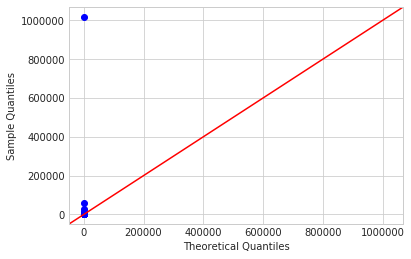

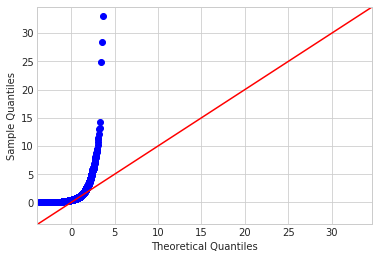

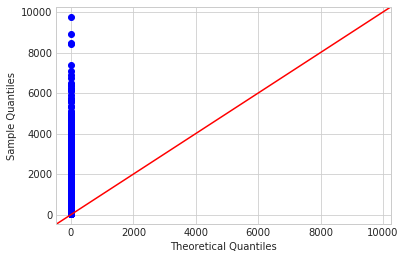

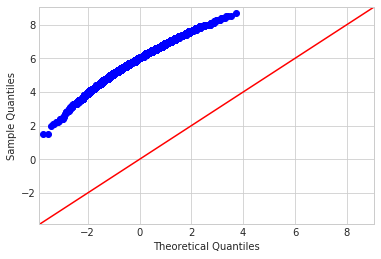

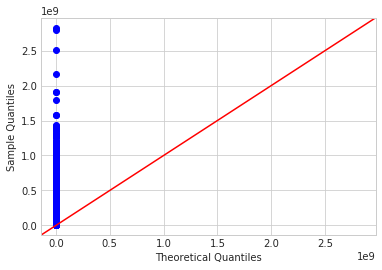

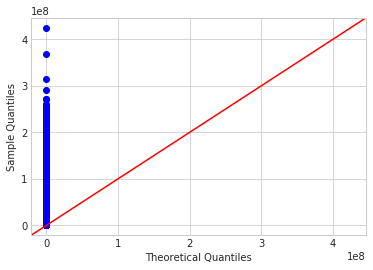

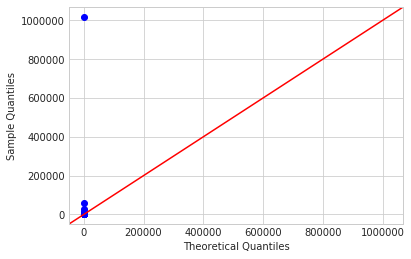

In [84]:
# First of all, we would want to know if popularity, vote count, 
#   vote average, and cash items follow a normal distribution or not.

qqplot(df.popularity, line='45' );
qqplot(df.vote_count, line='45')
qqplot(df.vote_average, line='45')
qqplot(df_money.revenue_adj, line='45')
qqplot(df_money.budget_adj, line='45')
qqplot(df_money.cash_eff, line='45')


#### None of the dependent variables aforementioned are normally distributed, therefore we shall employ non-parametric tests going forward.

Let's use the Mann-Whitney U test to check whether having a homepage or not impacts:

> 1. A movie's popularity.
> 2. Its vote count, and vote average.
> 3. Its cash variables.

To do that, we need to create 2 new dataframes, one for each category of homepage's variables.

In [85]:
#df for homepage = yes
df_hp_y = df.query('homepage == "Y"')

#df for homepage = no
df_hp_n = df.query('homepage == "N"')

In [86]:
# Compare the differences between popularity scores by homepage availability
print(stats.mannwhitneyu(df_hp_y.popularity, df_hp_n.popularity, alternative = 'two-sided'))

# Voting data by homepage availability
print()
print(stats.mannwhitneyu(df_hp_y.vote_count, df_hp_n.vote_count, alternative = 'two-sided'))

stats.mannwhitneyu(df_hp_y.vote_average, df_hp_n.vote_average, alternative = 'two-sided')

MannwhitneyuResult(statistic=11767119.5, pvalue=5.2305047982138503e-81)

MannwhitneyuResult(statistic=12436331.0, pvalue=2.9863778035192483e-132)


MannwhitneyuResult(statistic=10855175.0, pvalue=1.2471267693323675e-31)

There seems to be a high statistically significant difference between movies with a homepage, and those without. What about the cash variables? Let's create new dataframes using df_money dataframe.

In [87]:
# df_money for homepage = Yes
df_money_hp_y = df_money.query('homepage == "Y"')

# df_money for homepage = No
df_money_hp_n = df_money.query('homepage == "N"')

In [88]:
# Now let's see if cash variables are significantly different
#   according to homepage availability:

# Budget adjusted by homepage availability
print(stats.mannwhitneyu(df_money_hp_y.budget_adj, df_money_hp_n.budget_adj, alternative = 'two-sided'))

# Revenue adjusted by homepage availability
print()
print(stats.mannwhitneyu(df_money_hp_y.revenue_adj, df_money_hp_n.revenue_adj, alternative = 'two-sided'))

# Cash efficiency by homepage availability
stats.mannwhitneyu(df_money_hp_y.cash_eff, df_money_hp_n.cash_eff, alternative = 'two-sided')

MannwhitneyuResult(statistic=1808370.0, pvalue=0.00024881498676600092)

MannwhitneyuResult(statistic=1896928.5, pvalue=1.8970483867089943e-10)


MannwhitneyuResult(statistic=1870360.5, pvalue=2.7343884531335916e-08)

It seems that having a homepage makes for statistically significant differneces in cash variables as well. Let's not jump to conclusions, however, as there may be some **confounding** variables present. For example, having a homepage could be a privilege that only highend budget movies could afford, and naturally, these movies are more likely to become popular.

Let's visualize that data!

In [89]:
# Set chart background to a white grid
sns.set_style('whitegrid')

# Function to manually create legendls, inspired by
#  this Stackoverflow answer: 
#  https://stackoverflow.com/questions/33864578/matplotlib-making-labels-for-violin-plots

def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

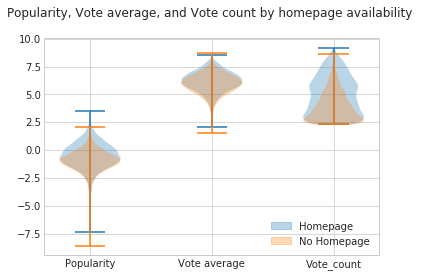

In [90]:
# Compare popularity (normalized by log), vote average, 
#   and vote count (normalized by log) by homepage
#   availability:

hp_y = [np.log(df_hp_y.popularity), df_hp_y.vote_average, np.log(df_hp_y.vote_count)]
hp_n = [np.log(df_hp_n.popularity), df_hp_n.vote_average, np.log(df_hp_n.vote_count)]

# Using a violin plot was the best option out of using simple
#   bargraphs, or boxplots, as it showed the distribution, and
#   contained the large skew in the data more efficiently.
labels = []
add_label(plt.violinplot(hp_y), "Homepage")
add_label(plt.violinplot(hp_n), "No Homepage")

# Plot title and X-axis labels
plt.xticks([1, 2, 3], ['Popularity', 'Vote average', 'Vote_count'])
plt.title('Popularity, Vote average, and Vote count by homepage availability \n');

# Add legend
plt.legend(*zip(*labels), loc=4);

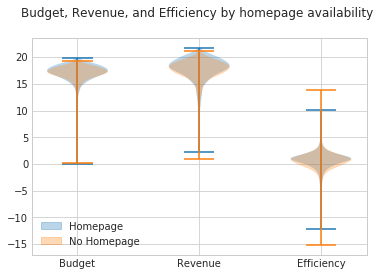

In [91]:
# Compare budget_adj, revenue_adj, and cash_eff
#   (all normalized by log) by homepage availability:

hp_money_y = [np.log(df_money_hp_y.budget_adj), np.log(df_money_hp_y.revenue_adj), np.log(df_money_hp_y.cash_eff)]
hp_money_n = [np.log(df_money_hp_n.budget_adj), np.log(df_money_hp_n.revenue_adj), np.log(df_money_hp_n.cash_eff)]

# Again, using violin plots
labels = []
add_label(plt.violinplot(hp_money_y), 'Homepage')
add_label(plt.violinplot(hp_money_n), 'No Homepage')

# Plot title and X-axis labels
plt.xticks([1, 2, 3], ['Budget', 'Revenue', 'Efficiency'])
plt.title('Budget, Revenue, and Efficiency by homepage availability \n');

# Add legends
plt.legend(*zip(*labels), loc=3);

### Who are the most successful actors, directors, and companies? What are the most popular/profitable genres?
First, we will need to create a modified dataframe, where we can group by the independent variable (actor, director, company, or genre). Then, we will use that dataframe to coalesce the dependent variables (cash/vote/popularity) for each independent variable, and visualize the data.

In [92]:
# master_df -> df or df_money
# variable -> cast, pc, or genre
def create_dataframe (master_df, variable):
    
    # The goal is to give each actor/company/genre in every column an entry with all their movie data, and
    #   append all these entries into a single dataframe. 
    
    
    # Duplicate the master_df 5 times, keeping a different variable column in each one
    df1 = master_df.copy().drop(['{}_2'.format(variable),
                                 '{}_3'.format(variable),
                                 '{}_4'.format(variable),
                                 '{}_5'.format(variable),], axis=1)
    df2 = master_df.copy().drop(['{}_3'.format(variable),
                                 '{}_4'.format(variable),
                                 '{}_5'.format(variable),
                                 '{}_1'.format(variable),], axis=1)
    df3 = master_df.copy().drop(['{}_4'.format(variable),
                                 '{}_5'.format(variable),
                                 '{}_1'.format(variable),
                                 '{}_2'.format(variable),], axis=1)
    df4 = master_df.copy().drop(['{}_5'.format(variable),
                                 '{}_1'.format(variable),
                                 '{}_2'.format(variable),
                                 '{}_3'.format(variable),], axis=1)
    df5 = master_df.copy().drop(['{}_1'.format(variable),
                                 '{}_2'.format(variable),
                                 '{}_3'.format(variable),
                                 '{}_4'.format(variable),], axis=1)
    
    
    #Check which variables to completely exclude from the dfs
    pc = ['pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5']
    cast =['cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5']
    genre =['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5']
    
    if variable == 'cast':
        df1 = df1.drop(pc+genre, axis=1)
        df2 = df2.drop(pc+genre, axis=1)
        df3 = df3.drop(pc+genre, axis=1)
        df4 = df4.drop(pc+genre, axis=1)
        df5 = df5.drop(pc+genre, axis=1)
    elif variable == 'pc':
        df1 = df1.drop(cast+genre, axis=1)
        df2 = df2.drop(cast+genre, axis=1)
        df3 = df3.drop(cast+genre, axis=1)
        df4 = df4.drop(cast+genre, axis=1)
        df5 = df5.drop(cast+genre, axis=1)
    elif variable == 'genre':
        df1 = df1.drop(cast+pc, axis=1)
        df2 = df2.drop(cast+pc, axis=1)
        df3 = df3.drop(cast+pc, axis=1)
        df4 = df4.drop(cast+pc, axis=1)
        df5 = df5.drop(cast+pc, axis=1)
    
    # Rename the variable in each df to have the same name in preparation for appending them together
    df1.rename(columns={'{}_1'.format(variable):variable}, inplace=True)
    df2.rename(columns={'{}_2'.format(variable):variable}, inplace=True)
    df3.rename(columns={'{}_3'.format(variable):variable}, inplace=True)
    df4.rename(columns={'{}_4'.format(variable):variable}, inplace=True)
    df5.rename(columns={'{}_5'.format(variable):variable}, inplace=True)
    
    
    # Drop entries with no values in the variable columns in each df
    df1.dropna(inplace=True)
    df2.dropna(inplace=True)
    df3.dropna(inplace=True)
    df4.dropna(inplace=True)
    df5.dropna(inplace=True)
    
    # Append all 5 dfs into a single df
    df_ready = df1.append([df2, df3, df4, df5], sort=False)
    
    return df_ready



Jeez, that was a lot of code! Our next function will use the database we just created to produce a series that can be plotted.

In [93]:
def create_series(variable, value, statistic):
    
    series_df = df_ready.groupby(variable, as_index=False)
    
    if statistic == 'mean':
        series_df = series_df.mean()
    elif statistic == 'median':
        series_df = series_df.median()
    elif statistic == 'sum':
        series_df = series_df.sum() 
    
    # Add a count of the number of movies for that release date/actor/production company/genre/director
    #  inspired by Andrew Willacy's project on Kaggle: https://www.kaggle.com/willacy/director-and-actor-s-total-gross-and-imdb-score
    var_key = df_ready[variable].value_counts().to_dict()
    series_df['count'] = series_df[variable].map(var_key)
    
    # Sort the series by the desired value in descending order
    series_df.sort_values(value, ascending=False, inplace=True)
    series_df[variable] = series_df[variable].map(str) + " (" + series_df['count'].astype(str) + ")"
   
    # Create the desired series so that it can be plotted
    series_ready = series_df[[variable, value]][10::-1].set_index(variable).iloc[:,0]
    
    return series_ready



Now, let's check which actors have been on the highest total movie budget, revenue, and efficiency.

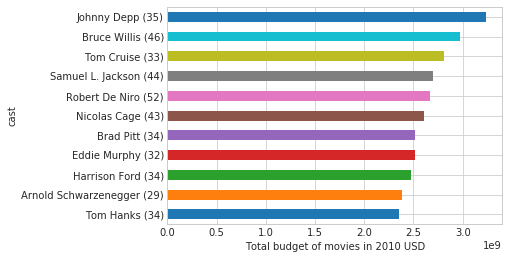

In [94]:
df_ready = create_dataframe(df_money, 'cast')
series_actor_budget = create_series('cast', 'budget_adj', 'sum')
series_actor_revenue = create_series('cast', 'revenue_adj', 'sum')
series_actor_efficiency = create_series('cast', 'cash_eff', 'mean')

series_actor_budget.plot(kind='barh')
plt.xlabel('Total budget of movies in 2010 USD');

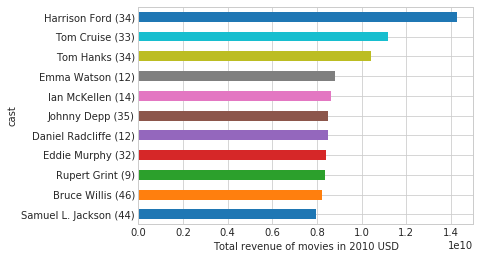

In [95]:
series_actor_revenue.plot(kind='barh');
plt.xlabel('Total revenue of movies in 2010 USD');

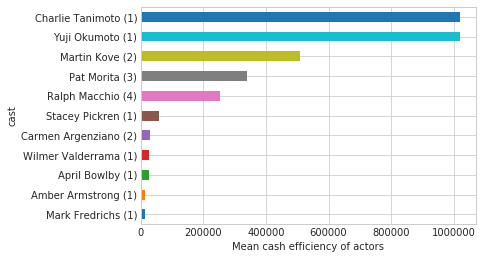

In [96]:
series_actor_efficiency.plot(kind='barh');
plt.xlabel('Mean cash efficiency of actors');

While **Johny Depp** topped the budget charts, **Harrison Ford** beats him by a large margin in total revenue. The cash efficiency charts shows a completely different list of contenders, most of which worked on a single movie only.

Let's check out which directors top the popularity, and vote charts:

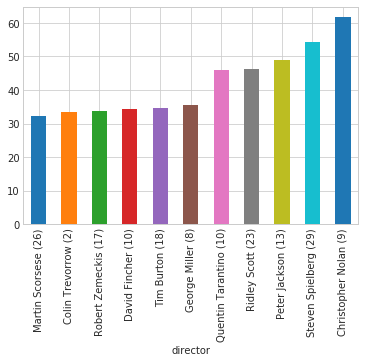

In [97]:
# Since directors are naturally present in their own column, we will use
#   the master dataframe, df, to conduct our analysis of popularity and vote data

df_ready = df
series_director_pop = create_series('director', 'popularity', 'sum')
series_director_count = create_series('director', 'vote_count', 'sum')
series_director_vote = create_series('director', 'vote_average', 'mean')

series_director_pop.plot(kind='bar');

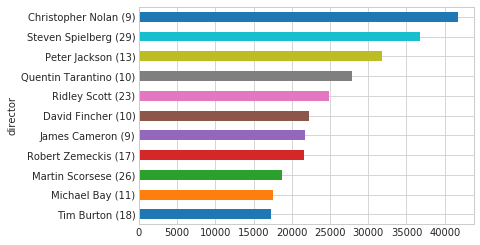

In [98]:
series_director_count.plot(kind='barh');

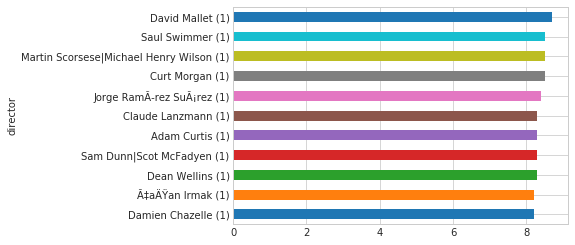

In [99]:
series_director_vote.plot(kind='barh');

**Christopher Nolan** tops both the popularity, and vote count charts, making him the most popular director in this database. He is not even a top 10 contender when it comes to the highest average vote chart; **David Mallet** comes on top with a single vote of approximately 9.0.

<a id='conclusions'></a>
## Conclusions

> For our first question, we performed some inferential statistics to see if having a homepage affected the metrics of a movie. All metrics tested displayed a statistical significance; having a homepage has a positive impact on all metrics. It is not clear whether this is a direct cause of homepages, or if there are confounding variables in play.

> For our second **set of questions**, we created two functions to help us sift through the data and rearrange it to be able to easily visualize the top 10 actors/directors/companies/genres's performance based on various dependent metrics.


In [101]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'The Hollywood Times.ipynb'])

0